In [39]:
from ipywidgets import Layout, HBox, VBox, Label, Checkbox, FloatText, Dropdown, BoundedIntText, Button
from properties import BoltMetric, Member, BoltConfig, MemberConfig
from pint import Quantity

class HorizontalLabeledInput:
    def __init__(self, label, input_field, unit_field=None):
        self.label = Label(value=label)
        self.input_field = input_field
        self.unit_field = unit_field

        children = [self.label, self.input_field]
        if self.unit_field is not None:
            children.append(self.unit_field)

        self.widget = HBox(children)

    def get_value(self):
        if self.unit_field is not None:
            # Construct pint quantity from input field and unit field
            return Quantity(self.input_field.value, self.unit_field.value)
        else:
            return self.input_field.value

    def get_widget(self):
        return self.widget

bolt_config = None
stackup_configs = []

is_tapped_hole_checkbox = Checkbox(value=False, description='Tapped Hole?')
engagement_length_input = HorizontalLabeledInput(
    "Thread Engagement Length:",
    FloatText(value=10.0, disabled=False),
    Dropdown(
        options=['mm', 'cm', 'm'],
        layout=Layout(width="auto")
    )
)

# Function to update visibility based on checkbox state
def update_isTappedHole_visibility(checked):
    if checked:
        engagement_length_input.get_widget().layout.display = 'flex'
    else:
        engagement_length_input.get_widget().layout.display = 'none'

# Connect the checkbox to the update function
is_tapped_hole_checkbox.observe(lambda change: update_isTappedHole_visibility(change['new']), names='value')
engagement_length_input.get_widget().layout.display = 'none'

nominal_size_input = HorizontalLabeledInput("Nom. Size:", Dropdown(options=BoltMetric.dimensional_props.get_entries()))
class_input = HorizontalLabeledInput("Class:", Dropdown(options=BoltMetric.class_props.get_entries()))
material_input = HorizontalLabeledInput("Material:", Dropdown(options=BoltMetric.material_props.get_entries()))
bolt_length_input = HorizontalLabeledInput(
    "Length:",
    FloatText(value=20.0, disabled=False),
    Dropdown(
        options=['mm', 'cm', 'm'],
        layout=Layout(width="auto")
    )
)
material_in_grip_thickness_input = HorizontalLabeledInput(
    "Material in grip thickness:",
    FloatText(value=10.0, disabled=False),
    Dropdown(
        options=['mm', 'cm', 'm'],
        layout=Layout(width="auto")
    )
)

bolt_info_layout = VBox([
    Label(value="Bolt Info"),
    is_tapped_hole_checkbox,
    nominal_size_input.get_widget(),
    class_input.get_widget(),
    material_input.get_widget(),
    bolt_length_input.get_widget(),
    material_in_grip_thickness_input.get_widget(),
    engagement_length_input.get_widget(),
], layout=Layout(align_items='flex-start'))

# TODO: Styling breaks down after 8 members
member_count_input = BoundedIntText(value=1, min=0, max=8, layout=Layout(width="auto"))

# Container for member rows
member_rows_container = VBox([])
member_inputs_list = []
member_materials_list = []

# Function to create a member row
def create_member_row(member_index):
    member_input = HorizontalLabeledInput(
        f"{member_index + 1}:",
        FloatText(value=2.0, description='Thickness:'),
        Dropdown(options=['mm', 'cm', 'm'], value='mm', layout=Layout(width="auto")),
    )
    return (member_input, Dropdown(options=Member.material_props.get_entries(), description='Material:'))

# Function to update member rows based on count
def update_member_rows(change):
    global member_inputs_list
    global member_materials_list

    new_count = change['new']
    current_count = len(member_rows_container.children)
    
    if new_count > current_count:
        # Recreate the stackup each time - not efficient - TODO: Fix
        for i in range(current_count, new_count):
            member_input, material_dropdown = create_member_row(i)
            member_rows_container.children = list(member_rows_container.children) + [HBox([member_input.get_widget(), material_dropdown])]
            member_inputs_list.append(member_input)
            member_materials_list.append(material_dropdown)

    elif new_count < current_count:
        # Remove excess rows
        member_rows_container.children = list(member_rows_container.children)[:new_count]
        member_inputs_list = member_inputs_list[:new_count]
        member_materials_list = member_materials_list[:new_count]
    
# Connect the count input to the update function
member_count_input.observe(update_member_rows, names='value')

# Initialize with one member
member_count_input.value = 4
update_member_rows({'new': 4})

# Scrollable container for members
scrollable_members = VBox([
    member_rows_container
], layout=Layout(
    max_height='300px',
    overflow_y='auto',
    border='1px solid #ccc',
    padding='5px'
))

member_info_layout = VBox([
    Label(value="Member Info"),
    HBox([Label(value="No. of Members:"), member_count_input]),
    scrollable_members
], layout=Layout(align_items='flex-start'))

def save_system_configuration(change):
    global bolt_config
    global stackup_configs

    bolt_config = None
    stackup_configs = []

    bolt_config = BoltConfig(
        min_tensile_yield_strength=BoltMetric.class_props.get(class_input.get_value(), field="min_tensile_yield_strength"),
        min_proof_strength=BoltMetric.class_props.get(class_input.get_value(), field="min_proof_strength"),
        pitch_coarse=BoltMetric.dimensional_props.get(nominal_size_input.get_value(), field="pitch_coarse"),
        coarse_tensile_stress_area=BoltMetric.dimensional_props.get(nominal_size_input.get_value(), field="coarse_tensile_stress_area"),
        nut_height=BoltMetric.dimensional_props.get(nominal_size_input.get_value(), field="nut_height"),
        head_diameter=BoltMetric.dimensional_props.get(nominal_size_input.get_value(), field="head_diameter"),
        nominal_diameter=BoltMetric.dimensional_props.get(nominal_size_input.get_value(), field="nominal_diameter"),
        elastic_modulus=BoltMetric.material_props.get(material_input.get_value(), field="elastic_modulus"),
        length=bolt_length_input.get_value()
    )
    for (idx, member_input) in enumerate(member_inputs_list):
        member_config = MemberConfig(
            thickness=member_input.get_value(),
            elastic_modulus=Member.material_props.get(member_materials_list[idx].value, field="elastic_modulus"),
            yield_strength=Member.material_props.get(member_materials_list[idx].value, field="yield_strength")
        )
        stackup_configs.append(member_config)

submit_button = Button(description="Calculate", button_style="success", layout=Layout(align_self='center'))
submit_button.on_click(save_system_configuration)

ui = VBox([
    HBox([
        bolt_info_layout, 
        member_info_layout
    ]),
    submit_button
])
ui

BoltConfig(min_tensile_yield_strength=<Quantity(400.0, 'megapascal')>, min_proof_strength=<Quantity(225.0, 'megapascal')>, pitch_coarse=<Quantity(1.0, 'millimeter')>, coarse_tensile_stress_area=<Quantity(20.1, 'millimeter ** 2')>, nut_height=<Quantity(5.2, 'millimeter')>, head_diameter=<Quantity(10.0, 'millimeter')>, nominal_diameter=<Quantity(6.0, 'millimeter')>, elastic_modulus=<Quantity(207.0, 'gigapascal')>, length=<Quantity(20.0, 'millimeter')>)
[MemberConfig(thickness=<Quantity(2.0, 'millimeter')>, elastic_modulus=<Quantity(69000.0, 'megapascal')>, yield_strength=<Quantity(276.0, 'megapascal')>), MemberConfig(thickness=<Quantity(2.0, 'millimeter')>, elastic_modulus=<Quantity(69000.0, 'megapascal')>, yield_strength=<Quantity(276.0, 'megapascal')>), MemberConfig(thickness=<Quantity(4.0, 'millimeter')>, elastic_modulus=<Quantity(69000.0, 'megapascal')>, yield_strength=<Quantity(276.0, 'megapascal')>), MemberConfig(thickness=<Quantity(4.0, 'millimeter')>, elastic_modulus=<Quantity(69

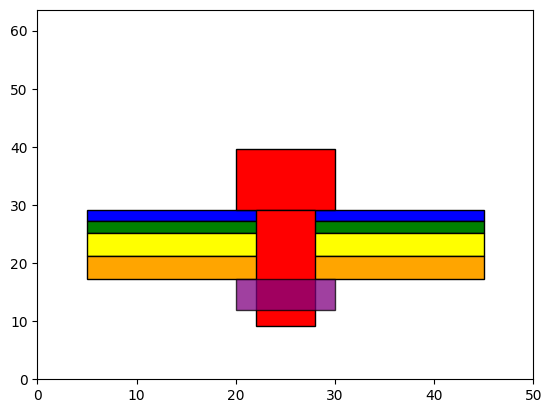

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


print(bolt_config)
print(stackup_configs)

head_diameter = bolt_config.head_diameter.to("mm").magnitude
nut_height = bolt_config.nut_height.to("mm").magnitude
shaft_diameter = bolt_config.nominal_diameter.to("mm").magnitude
bolt_length = bolt_config.length.to("mm").magnitude

# 5 times the bolt head diameter
CANVAS_WIDTH = 5 * head_diameter
total_stackup_thickness = sum(member.thickness.to("mm").magnitude for member in stackup_configs)
CANVAS_HEIGHT = (2 * nut_height + bolt_length + total_stackup_thickness) * 1.5


fig, ax = plt.subplots()
bolt_head = Rectangle(
    (CANVAS_WIDTH / 2 - head_diameter / 2, CANVAS_HEIGHT / 2 - nut_height / 2), 
    head_diameter, 
    nut_height*2, 
    angle=0, fill=True, facecolor='red', 
    edgecolor='black', 
    linewidth=1
)

shaft = Rectangle(
    (CANVAS_WIDTH / 2 - shaft_diameter / 2, CANVAS_HEIGHT / 2 - nut_height / 2), 
    shaft_diameter, 
    -bolt_length, 
    angle=0, fill=True, facecolor='red', 
    edgecolor='black', 
    linewidth=1,
    alpha=0.9
)

y_offset = 0
colors = ['blue', 'green', 'yellow', 'orange', 'brown', 'pink']
for (idx, member) in enumerate(stackup_configs):
    member_thickness = member.thickness.to("mm").magnitude
    member = Rectangle(
        (0.1 * CANVAS_WIDTH, CANVAS_HEIGHT / 2 - nut_height / 2 - y_offset),
        0.8 * CANVAS_WIDTH,
        -member_thickness,
        angle=0, fill=True, facecolor=colors[idx % len(colors)],
        edgecolor='black',
        linewidth=1
    )
    y_offset += member_thickness
    ax.add_patch(member)

nut = Rectangle(
    (CANVAS_WIDTH / 2 - head_diameter / 2, CANVAS_HEIGHT / 2 - nut_height / 2 - y_offset), 
    head_diameter, 
    -nut_height, 
    angle=0, fill=True, facecolor='purple', 
    edgecolor='black', 
    linewidth=1,
    alpha=0.75
)

ax.add_patch(bolt_head)
ax.add_patch(shaft)
ax.add_patch(nut)
ax.set_xlim(0, CANVAS_WIDTH)
ax.set_ylim(0, CANVAS_HEIGHT)

plt.show()